In [1]:
# Importing libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

import jax.numpy as jnp
from jax import random

# Optional: allow parallel chains
numpyro.set_host_device_count(4)


In [2]:
# Load dataset given 
data = pd.read_csv("component-data-2c.csv")

# Check the structure
print(data)

# Split- Training components (index 0–49) and Blind test components (index 50–74)
train_data = data[data['index'] < 50]
test_data = data[data['index'] >= 50]


         ID  index     X1     X2     X3     X4     X5  day  integrity
0    K#0000      0  1.897  1.111  0.585  1.436  3.684  1.0     94.203
1    K#0000      0  1.897  1.111  0.585  1.436  3.684  3.0     90.663
2    K#0000      0  1.897  1.111  0.585  1.436  3.684  5.0     76.650
3    K#0000      0  1.897  1.111  0.585  1.436  3.684  7.0     74.893
4    K#0000      0  1.897  1.111  0.585  1.436  3.684  8.0     73.923
..      ...    ...    ...    ...    ...    ...    ...  ...        ...
874  K#0073     73  1.062  5.715  1.264  1.741  1.627  5.0     75.489
875  K#0074     74  0.798  1.935  0.171  0.905  2.366  3.0     86.792
876  K#0074     74  0.798  1.935  0.171  0.905  2.366  6.0     88.145
877  K#0074     74  0.798  1.935  0.171  0.905  2.366  7.0     75.088
878  K#0074     74  0.798  1.935  0.171  0.905  2.366  9.0     68.078

[879 rows x 9 columns]


In [3]:
#Define Baseline model

def baseline_model(index, day, integrity):
    num_components = int(index.max()) + 1

    # Hyperprior for u and v (mu and sigma)
    mu_u = numpyro.sample("mu_u", dist.Normal(90.0, 10.0))  # Prior for intercept mean
    sigma_u = numpyro.sample("sigma_u", dist.HalfNormal(5.0))  # Prior for intercept std

    mu_v = numpyro.sample("mu_v", dist.Normal(5.0, 2.0))  # Prior for decay mean
    sigma_v = numpyro.sample("sigma_v", dist.HalfNormal(2.0))  # Prior for decay std

    # Component-level parameters
    u = numpyro.sample("u", dist.Normal(mu_u, sigma_u).expand([num_components]))
    v = numpyro.sample("v", dist.Normal(mu_v, sigma_v).expand([num_components]))

    # Observation noise
    sigma_y = numpyro.sample("sigma_y", dist.HalfNormal(5.0))

    # Expected integrity
    f = u[index] * jnp.exp(-v[index] * day / 100)

    # Likelihood
    numpyro.sample("obs", dist.Normal(f, sigma_y), obs=integrity)


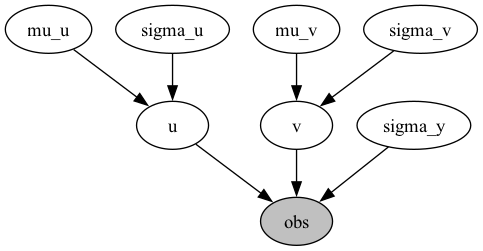

In [4]:
# Render the model to a file (e.g., "model.png") for visualization
index_train = train_data['index'].values
day_train = train_data['day'].values
integrity_train = train_data['integrity'].values

numpyro.render_model(
    baseline_model,
    model_args=(index_train, day_train, integrity_train), 
    filename="baseline_model.png", 
    render_params=True
)


# If running in a Jupyter notebook, you can display it directly
from IPython.display import Image
Image(filename="baseline_model.png")


In [5]:
#Run MCMC Sampling for baseline model
# Prepare data
index_train = train_data['index'].values
day_train = train_data['day'].values
integrity_train = train_data['integrity'].values

# RNG key
rng_key = random.PRNGKey(0)

# Setup HMC
kernel = NUTS(baseline_model)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=2000, num_chains=4, progress_bar=False)
mcmc.run(rng_key, index=index_train, day=day_train, integrity=integrity_train)

# Print the summary of the MCMC run
mcmc.print_summary()

# Save samples
posterior_samples = mcmc.get_samples()




                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_u     89.75      0.99     89.76     88.09     91.35   8376.06      1.00
      mu_v      3.97      0.23      3.97      3.61      4.36  10391.38      1.00
   sigma_u      5.36      0.86      5.31      3.95      6.74   4661.10      1.00
   sigma_v      1.50      0.17      1.49      1.23      1.77   8156.32      1.00
   sigma_y      5.03      0.14      5.03      4.81      5.25  10792.05      1.00
      u[0]     94.07      2.28     94.07     90.21     97.64  10772.03      1.00
      u[1]     87.33      4.39     87.36     80.00     94.26   9844.14      1.00
      u[2]     98.63      2.24     98.62     94.83    102.23   9024.14      1.00
      u[3]     89.29      2.12     89.26     86.02     92.98  10202.89      1.00
      u[4]     86.96      3.96     87.01     80.57     93.50  11564.17      1.00
      u[5]     89.30      4.15     89.26     82.45     95.99  11585.88      1.00
      u[6]     91.67      3

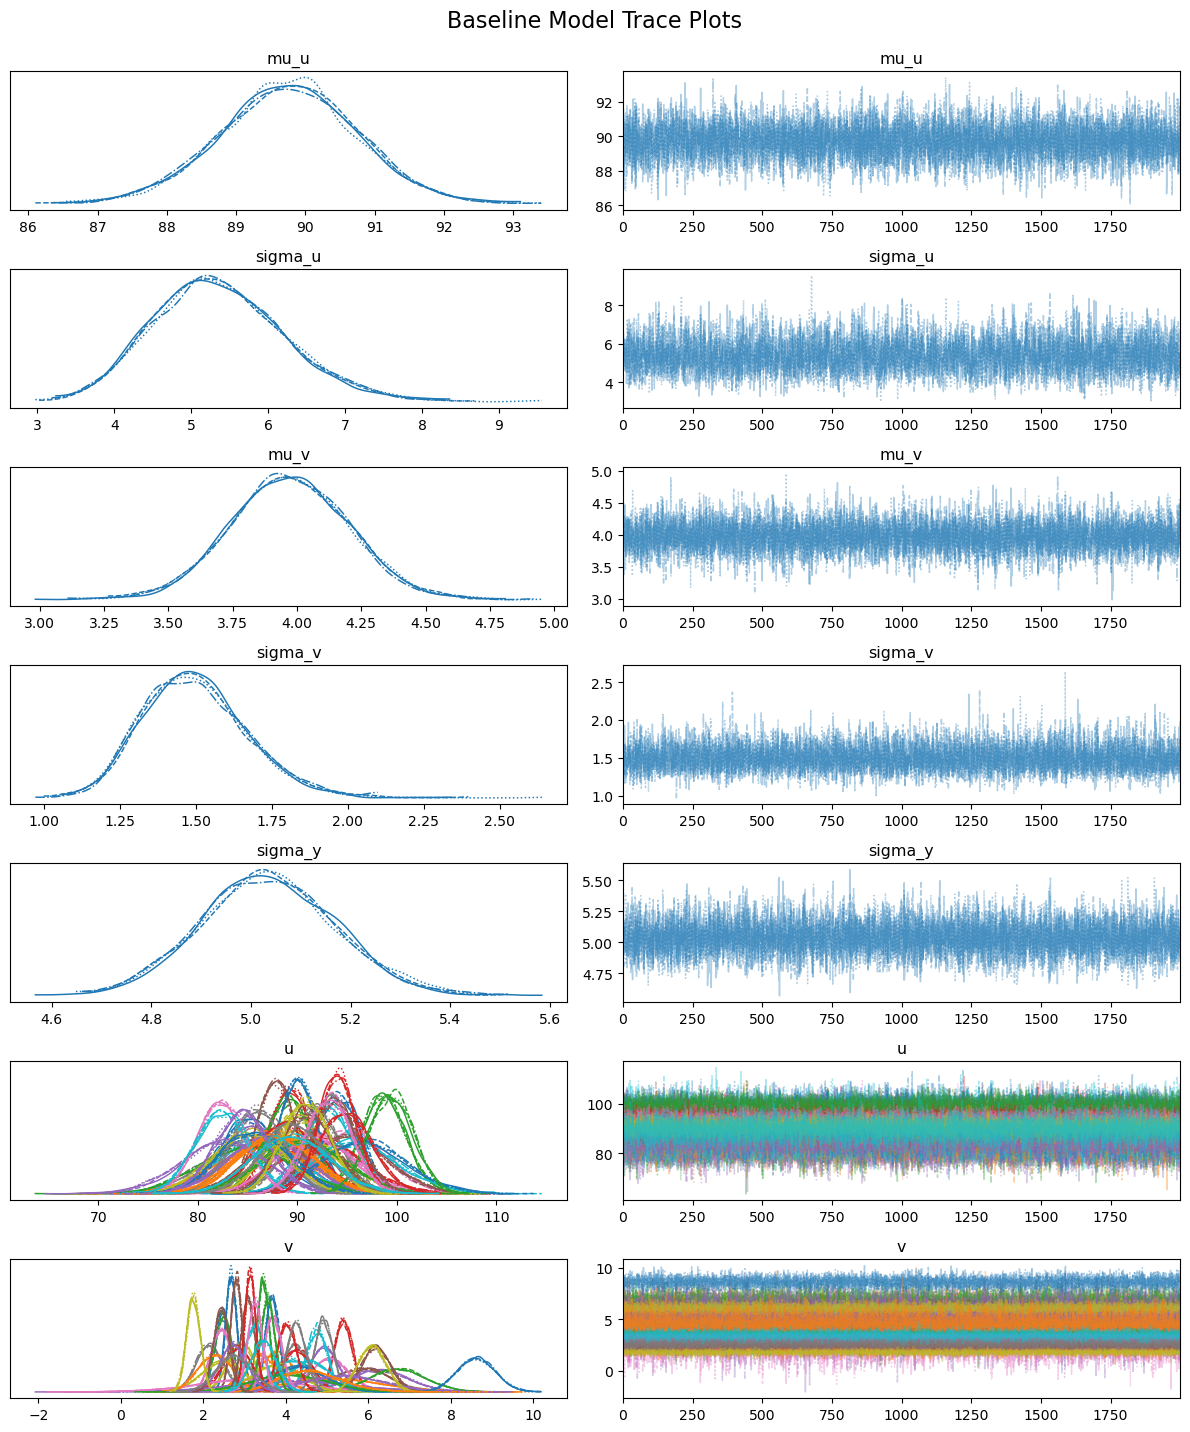

In [6]:
# Generate arviz trace plots for baseline model
az_data_baseline = az.from_numpyro(mcmc)  # `mcmc` is for baseline
az.plot_trace(
    az_data_baseline,
    var_names=["mu_u", "sigma_u", "mu_v", "sigma_v", "sigma_y", "u", "v"],
    compact=True
)
plt.tight_layout()  
plt.suptitle('Baseline Model Trace Plots', fontsize=16, y=1.02) 
plt.show()


In [7]:
#Define Enhanced Degradation model 

def enhanced_model(index, day, integrity, x_features):
    num_components = int(index.max()) + 1

    # Hyperpriors
    mu_u = numpyro.sample("mu_u", dist.Normal(90.0, 10.0))
    sigma_u = numpyro.sample("sigma_u", dist.HalfNormal(5.0))

    mu_v = numpyro.sample("mu_v", dist.Normal(5.0, 2.0))
    sigma_v = numpyro.sample("sigma_v", dist.HalfNormal(2.0))

    # Global feature weight priors
    w = numpyro.sample("w", dist.Normal(0.0, 1.0).expand([5]))

    # Component-level parameters
    u = numpyro.sample("u", dist.Normal(mu_u, sigma_u).expand([num_components]))
    v = numpyro.sample("v", dist.Normal(mu_v, sigma_v).expand([num_components]))

    sigma_y = numpyro.sample("sigma_y", dist.HalfNormal(5.0))

    # Adjusted decay
    decay = v[index] + jnp.dot(x_features, w)

    f = u[index] * jnp.exp(-decay * day / 100)

    numpyro.sample("obs", dist.Normal(f, sigma_y), obs=integrity)


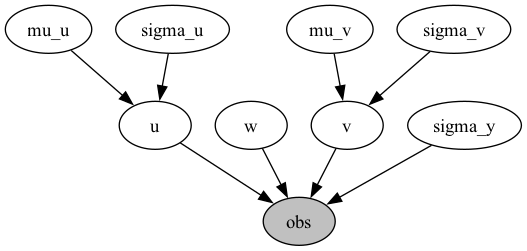

In [8]:
# Render the model to a file (e.g., "model.png") for visualization

# Prepare features
x_features_train = train_data[["X1", "X2", "X3", "X4", "X5"]].values

index_train = train_data['index'].values
day_train = train_data['day'].values
integrity_train = train_data['integrity'].values

numpyro.render_model(
    enhanced_model,
    model_args=(index_train, day_train, integrity_train, x_features_train), 
    filename="enhanced_model.png", 
    render_params=True
)


# If running in a Jupyter notebook, you can display it directly
from IPython.display import Image
Image(filename="enhanced_model.png")


In [9]:
#Run MCMC Sampling for enhanced model

# Setup HMC
kernel_enhanced = NUTS(enhanced_model)
mcmc_enhanced = MCMC(kernel_enhanced, num_warmup=2000, num_samples=2000, num_chains=4, progress_bar=False)
mcmc_enhanced.run(rng_key, index=index_train, day=day_train, integrity=integrity_train, x_features=x_features_train)

# Print the summary of the MCMC run
mcmc_enhanced.print_summary()

# Save samples
posterior_samples_enhanced = mcmc_enhanced.get_samples()




                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_u     90.21      0.91     90.22     88.64     91.63   6438.23      1.00
      mu_v      2.00      0.17      1.99      1.71      2.25    750.77      1.00
   sigma_u      5.01      0.73      4.96      3.83      6.18   4728.11      1.00
   sigma_v      0.36      0.07      0.35      0.25      0.47   2480.10      1.00
   sigma_y      5.03      0.13      5.03      4.82      5.25  11296.86      1.00
      u[0]     94.26      2.16     94.26     90.64     97.76  12630.59      1.00
      u[1]     91.65      3.91     91.55     85.27     98.05   7978.66      1.00
      u[2]     98.59      2.15     98.54     95.06    102.06   7273.20      1.00
      u[3]     89.58      2.05     89.57     86.13     92.87  11105.94      1.00
      u[4]     89.36      3.38     89.34     83.70     94.76  10860.11      1.00
      u[5]     88.01      3.62     87.99     82.11     94.01  12022.83      1.00
      u[6]     91.35      2

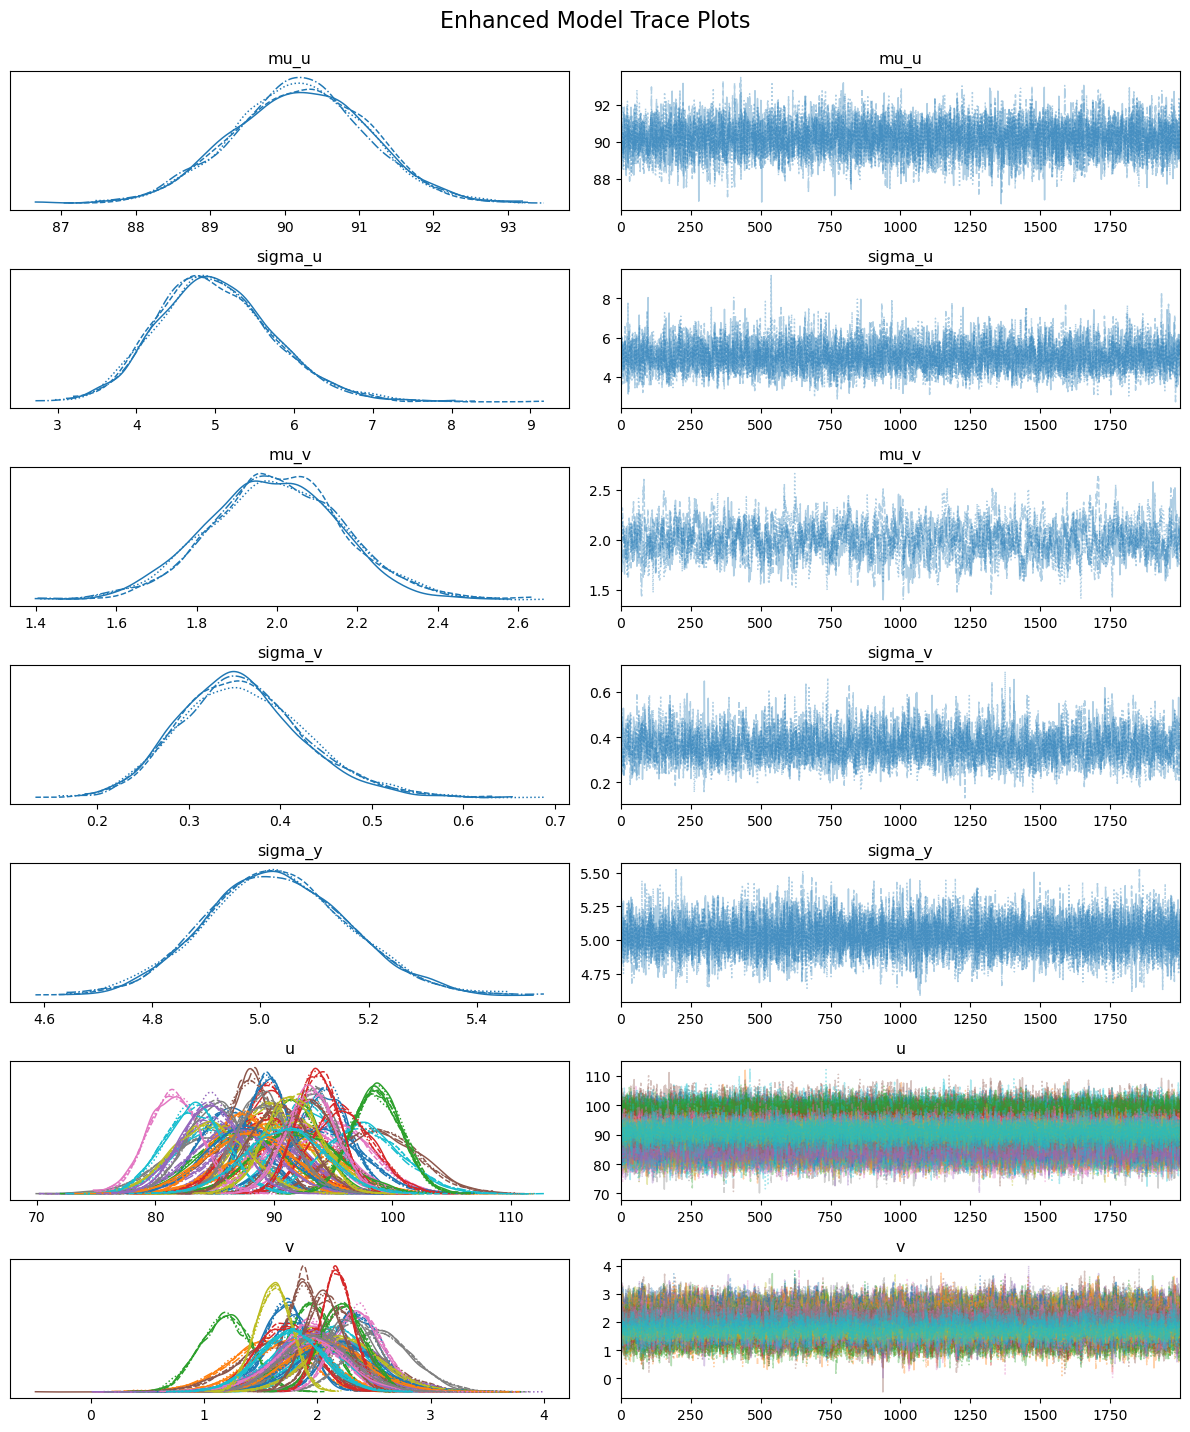

In [10]:
# Generate arviz trace plots for enhanced model (without w_j yet)
az_data_enhanced = az.from_numpyro(mcmc_enhanced)  # `mcmc_enhanced` is for enhanced
az.plot_trace(
    az_data_enhanced,
    var_names=["mu_u", "sigma_u", "mu_v", "sigma_v", "sigma_y", "u", "v"],
    compact=True
)
plt.tight_layout()  
plt.suptitle('Enhanced Model Trace Plots', fontsize=16, y=1.02)  # move title up a bit
plt.show()


In [11]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Function to plot side-by-side comparisons
def plot_model_fit_comparison(samples_baseline, samples_enhanced, data_df, component_idx, x_features_df=None, days_max=60):
    t_plot = jnp.linspace(0, days_max, 100)
    
    # Setup figure
    fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    
    # Plot for Baseline Model
    u_samples_base = samples_baseline['u'][:, component_idx]
    v_samples_base = samples_baseline['v'][:, component_idx]
    
    decay_samples_base = v_samples_base
    f_samples_base = (u_samples_base[:, None]) * jnp.exp(-decay_samples_base[:, None] * t_plot / 100)
    
    f_mean_base = f_samples_base.mean(axis=0)
    f_std_base = f_samples_base.std(axis=0)
    noise_std_base = samples_baseline['sigma_y'].mean()
    f_total_std_base = jnp.sqrt(f_std_base**2 + noise_std_base**2)
    
    axs[0].plot(t_plot, f_mean_base, color='blue', label="Posterior Predictive Mean")
    axs[0].fill_between(t_plot, f_mean_base - 1.96*f_std_base, f_mean_base + 1.96*f_std_base, color='blue', alpha=0.3, label="Function Uncertainty (95%)")
    axs[0].fill_between(t_plot, f_mean_base - 1.96*f_total_std_base, f_mean_base + 1.96*f_total_std_base, color='blue', alpha=0.15, label="Total Uncertainty (95%)")
    df_component = data_df[data_df['index'] == component_idx]
    axs[0].scatter(df_component['day'], df_component['integrity'], color='red', label="Observed Data")
    axs[0].set_title(f"Baseline Model - Component {component_idx}")
    axs[0].set_xlabel("Day")
    axs[0].set_ylabel("Integrity (%)")
    axs[0].grid()
    axs[0].legend()

    # Plot for Enhanced Model
    u_samples_enh = samples_enhanced['u'][:, component_idx]
    v_samples_enh = samples_enhanced['v'][:, component_idx]
    w_samples_enh = samples_enhanced['w']

    x_feat = x_features_df[data_df['index'] == component_idx][0]
    decay_samples_enh = v_samples_enh + (w_samples_enh @ x_feat)

    f_samples_enh = (u_samples_enh[:, None]) * jnp.exp(-decay_samples_enh[:, None] * t_plot / 100)

    f_mean_enh = f_samples_enh.mean(axis=0)
    f_std_enh = f_samples_enh.std(axis=0)
    noise_std_enh = samples_enhanced['sigma_y'].mean()
    f_total_std_enh = jnp.sqrt(f_std_enh**2 + noise_std_enh**2)

    axs[1].plot(t_plot, f_mean_enh, color='green', label="Posterior Predictive Mean")
    axs[1].fill_between(t_plot, f_mean_enh - 1.96*f_std_enh, f_mean_enh + 1.96*f_std_enh, color='green', alpha=0.3, label="Function Uncertainty (95%)")
    axs[1].fill_between(t_plot, f_mean_enh - 1.96*f_total_std_enh, f_mean_enh + 1.96*f_total_std_enh, color='green', alpha=0.15, label="Total Uncertainty (95%)")
    axs[1].scatter(df_component['day'], df_component['integrity'], color='red', label="Observed Data")
    axs[1].set_title(f"Enhanced Model - Component {component_idx}")
    axs[1].set_xlabel("Day")
    axs[1].grid()
    axs[1].legend()
    
    plt.suptitle(f"Comparison of Model Fits for Component {component_idx}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [12]:
# Extract features X1–X5 for test set
x_features_test = test_data[['X1', 'X2', 'X3', 'X4', 'X5']].values

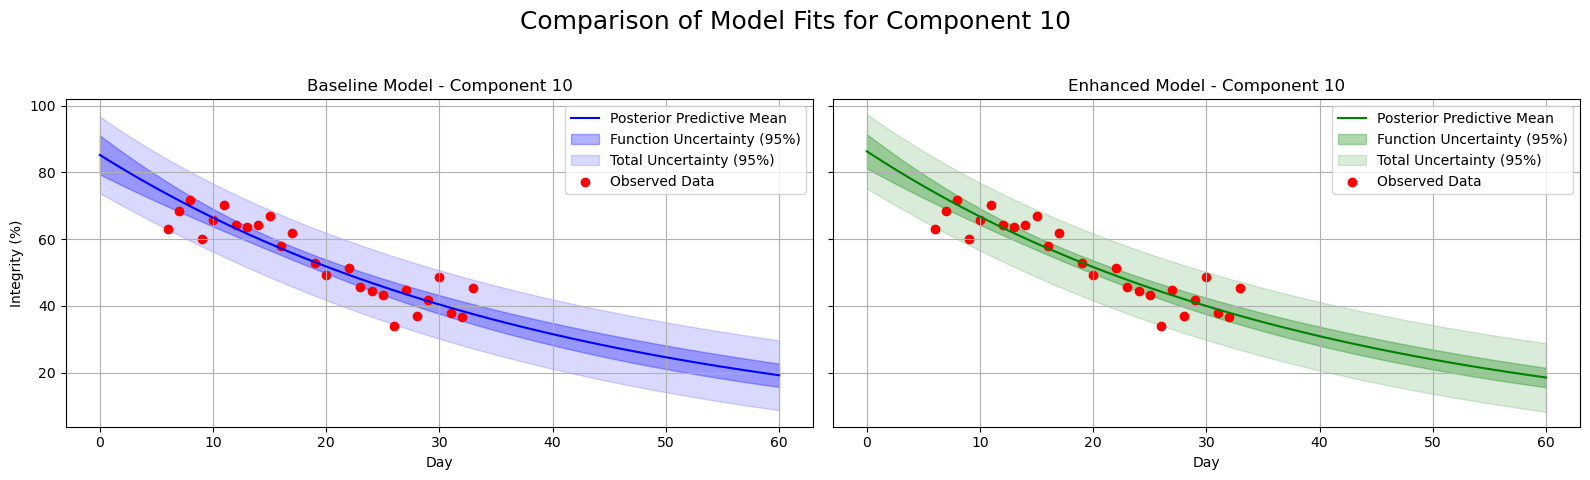

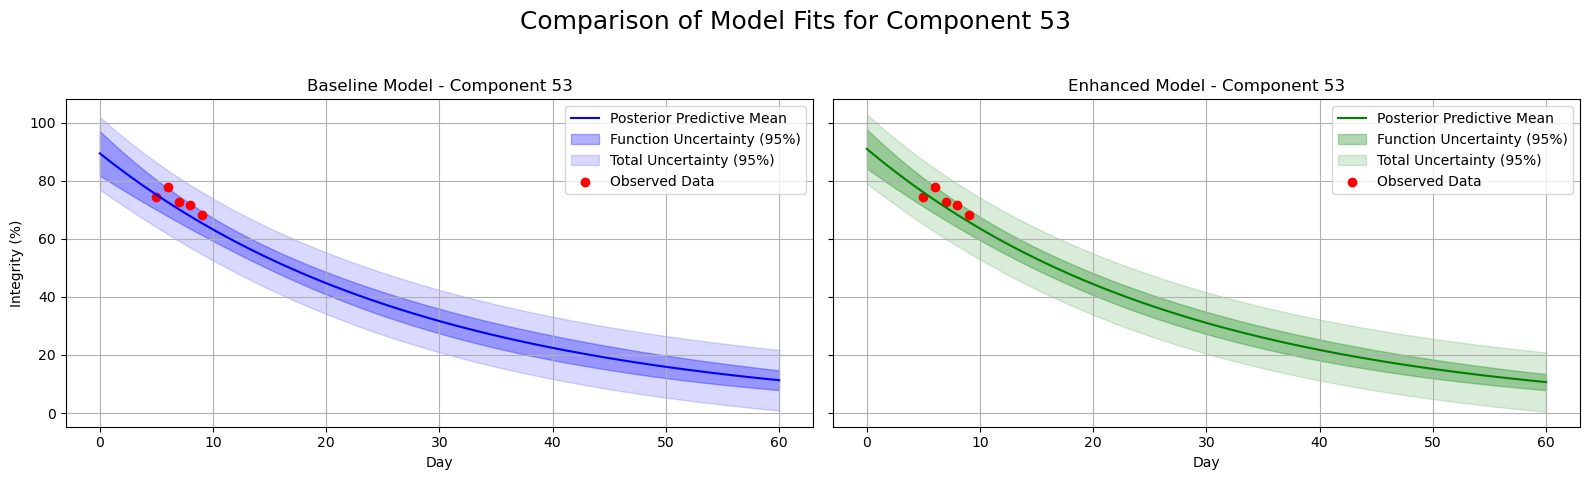

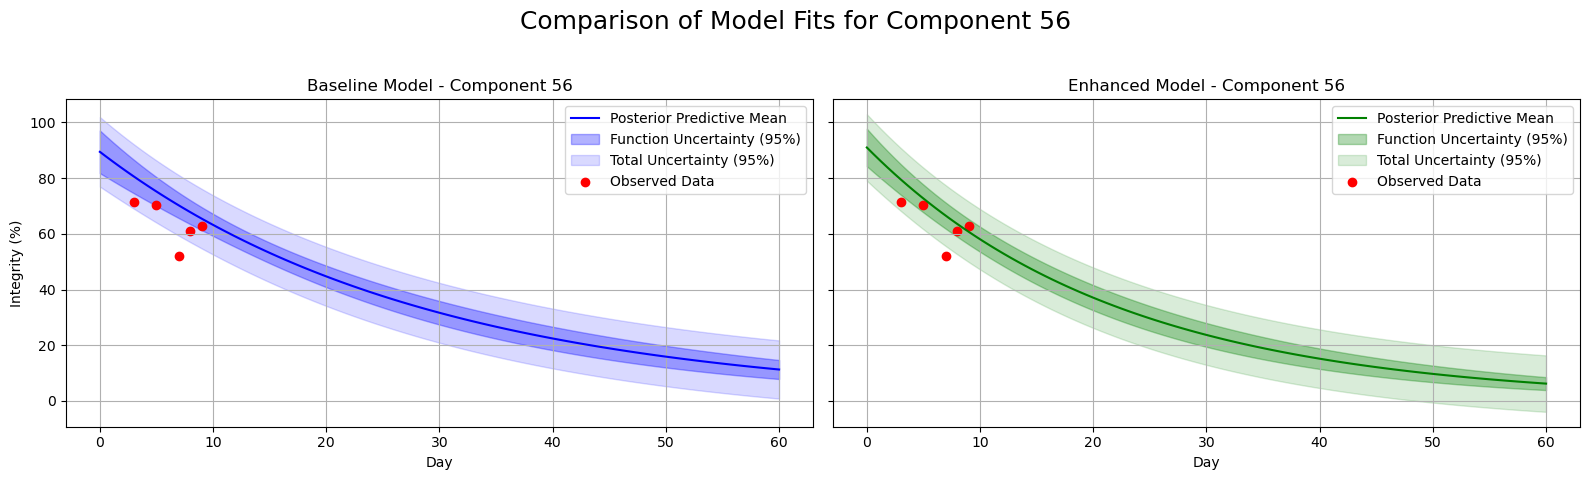

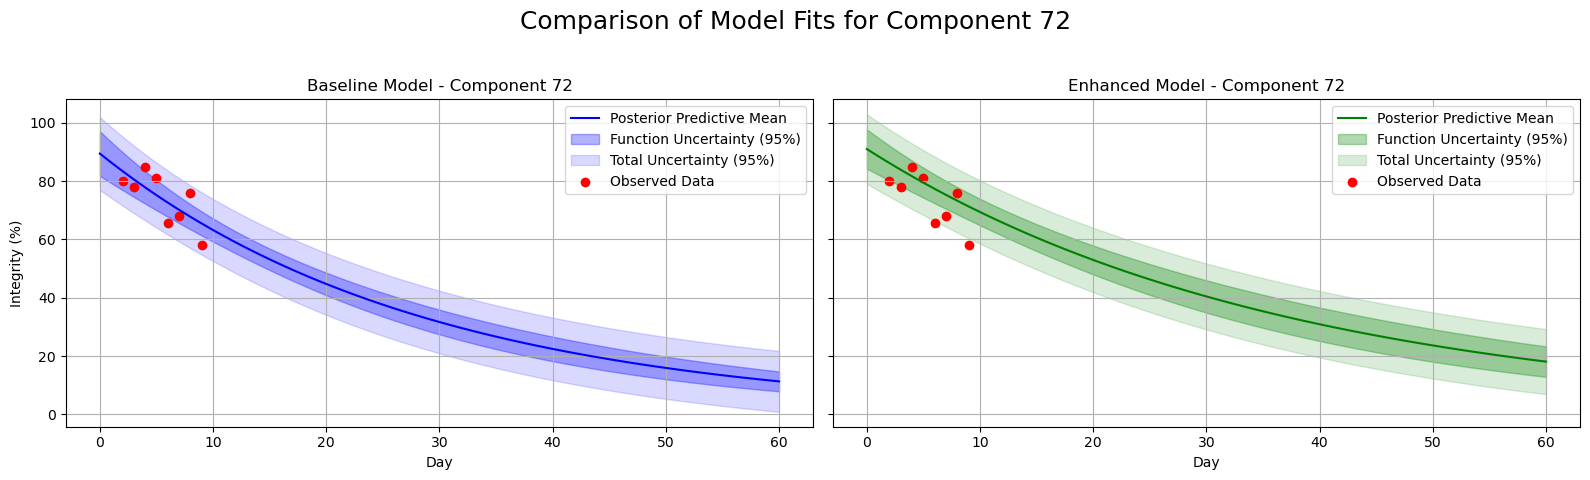

In [13]:
plot_model_fit_comparison(posterior_samples, posterior_samples_enhanced, train_data, component_idx=10, x_features_df=x_features_train)
plot_model_fit_comparison(posterior_samples, posterior_samples_enhanced, test_data, component_idx=53, x_features_df=x_features_test)
plot_model_fit_comparison(posterior_samples, posterior_samples_enhanced, test_data, component_idx=56, x_features_df=x_features_test)
plot_model_fit_comparison(posterior_samples, posterior_samples_enhanced, test_data, component_idx=72, x_features_df=x_features_test)


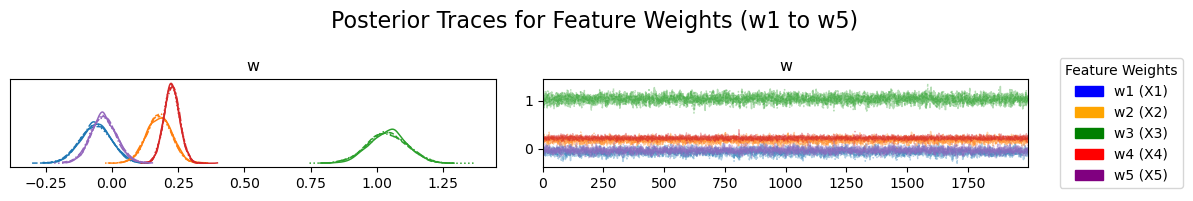

In [14]:
#Plot trace output for weight parameter wj 
import matplotlib.patches as mpatches

# First do the normal plot
az.plot_trace(
    az_data_enhanced,
    var_names=["w"],
    compact=True
)
plt.suptitle('Posterior Traces for Feature Weights (w1 to w5)', fontsize=16)

# observed colors are blue, orange, green, red, purple (default matplotlib cycle)

colors = ['blue', 'orange', 'green', 'red', 'purple']
labels = ['w1 (X1)', 'w2 (X2)', 'w3 (X3)', 'w4 (X4)', 'w5 (X5)']

patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(5)]

# Add the legend to the figure
plt.legend(handles=patches, title="Feature Weights", bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()

plt.show()



In [15]:
#Black box model
#First, find components with measurements at or near t=30
selected_indices = []

for idx in data['index'].unique():
    df_comp = data[data['index'] == idx]
    
    # Check if there is any day close to t=30 (+/- 1 day margin)
    if np.any(np.isclose(df_comp['day'].values, 30, atol=1.0)):
        selected_indices.append(idx)

# Now extract only those components
data_up_to_30 = data[data['index'].isin(selected_indices)]

print(f"Selected {len(selected_indices)} components with data near t=30.")


Selected 23 components with data near t=30.


In [16]:
#Black box model 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



def create_blackbox_features(df):
    components = []
    
    for idx in df['index'].unique():
        df_comp = df[df['index'] == idx]
        df_comp_0_10 = df_comp[df_comp['day'] <= 10]
        
        if df_comp_0_10.shape[0] < 2:
            # Skip components with too little data before t=10
            continue
        
        mean_integrity = df_comp_0_10['integrity'].mean()
        mean_log_integrity = np.log1p(df_comp_0_10['integrity']).mean()
        
        # Gradient (simple linear regression slope)
        times = df_comp_0_10['day'].values
        values = df_comp_0_10['integrity'].values
        
        slope = np.polyfit(times, values, 1)[0]  # 1st degree = linear slope
        
        # Get component features (X1-X5)
        x_features = df_comp[['X1', 'X2', 'X3', 'X4', 'X5']].values[0]
        
        # Try to get target value at t=30 if available
        integrity_t30 = df_comp[np.isclose(df_comp['day'], 30, atol=1.0)]
        if integrity_t30.shape[0] == 0:
            continue  # skip if no data near t=30
        
        target_value = integrity_t30['integrity'].values[0]
        
        feature_vector = [idx, mean_integrity, mean_log_integrity, slope] + list(x_features) + [target_value]
        components.append(feature_vector)
        
    columns = ['index', 'mean_integrity', 'mean_log_integrity', 'slope', 'X1', 'X2', 'X3', 'X4', 'X5', 'target_integrity']
    feature_df = pd.DataFrame(components, columns=columns)
    
    return feature_df


# Create black-box dataset
blackbox_df = create_blackbox_features(data_up_to_30)  # Only training components 0-49

# Features and targets
X = blackbox_df[['mean_integrity', 'mean_log_integrity', 'slope', 'X1', 'X2', 'X3', 'X4', 'X5']]
y = blackbox_df['target_integrity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose your model: LinearRegression
model = LinearRegression()

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


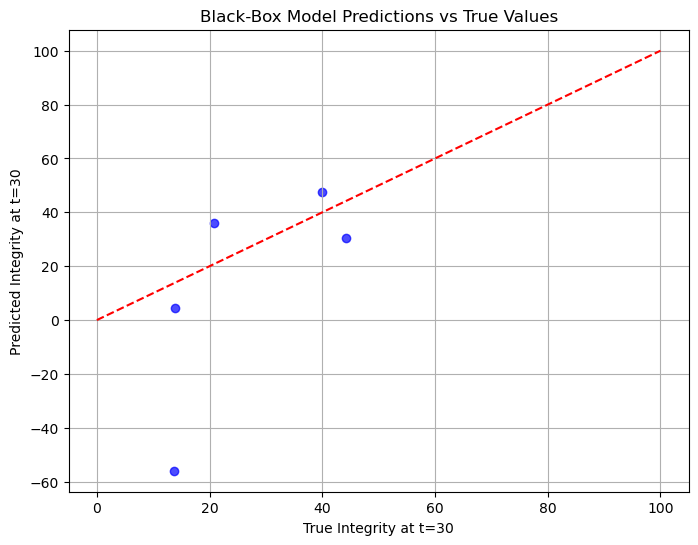

In [17]:
# Plot predictions vs true values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([0, 100], [0, 100], '--r')  # Perfect prediction line
plt.xlabel("True Integrity at t=30")
plt.ylabel("Predicted Integrity at t=30")
plt.title("Black-Box Model Predictions vs True Values")
plt.grid()
plt.show()


In [18]:
#Blind test prediction

#Define prediction function

def predict_failure_probability(samples, test_data, x_features_test, t_future=30):
    prob_list = []

    for idx in sorted(test_data['index'].unique()):
        # Extract samples for component idx
        u_samples = samples['u'][:, idx]
        v_samples = samples['v'][:, idx]
        w_samples = samples['w']

        # Extract feature vector for component
        x_feat = test_data[test_data['index'] == idx][['X1', 'X2', 'X3', 'X4', 'X5']].values[0]

        # Adjusted decay based on feature
        decay_samples = v_samples + jnp.dot(w_samples, x_feat)

        # Predicted function value at t=30
        f_t30_samples = u_samples * jnp.exp(-decay_samples * t_future / 100)

        # Compute probability that integrity <= 30%
        prob = (f_t30_samples <= 30).mean()
        
        # Append as tuple (ID string, index number, probability value)
        prob_list.append((f"K#{idx:04d}", idx, prob))

    return pd.DataFrame(prob_list, columns=["ID", "index", "probability"])


In [19]:
#Blind test prediction on test data 

# Selected test data (index 50 to 74)
#test_data = data[data['index'] >= 50].copy()

# Generate the predictions using the posterior samples from enhanced model
blind_predictions = predict_failure_probability(
    posterior_samples_enhanced,
    test_data,
    x_features_test,
    t_future=30
)
print(blind_predictions)

        ID  index  probability
0   K#0050     50          0.0
1   K#0051     51          1.0
2   K#0052     52          1.0
3   K#0053     53   0.30075002
4   K#0054     54          0.0
5   K#0055     55     0.947125
6   K#0056     56   0.99500006
7   K#0057     57          0.0
8   K#0058     58          1.0
9   K#0059     59     0.591125
10  K#0060     60        0.002
11  K#0061     61          0.0
12  K#0062     62       0.0005
13  K#0063     63      0.00175
14  K#0064     64          0.0
15  K#0065     65      0.99975
16  K#0066     66          1.0
17  K#0067     67          1.0
18  K#0068     68  0.012375001
19  K#0069     69          1.0
20  K#0070     70     0.993125
21  K#0071     71     0.786875
22  K#0072     72          0.0
23  K#0073     73   0.99112505
24  K#0074     74          0.0


In [20]:
# Save to predictions.csv
blind_predictions.to_csv("predictions.csv", index=False)